In [2]:
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from AccSGD import *

class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2,1)
        
    def forward(self, x):
        out = self.fc(x) 
        return out

In [3]:
#* code in this block was provided in ICLR 2018 confenece paper 
#* 'On the Insufficiency of Existing Momentum Schemes for Stochastic Optimization'
from torch.optim.optimizer import Optimizer, required
import copy

class AccSGD(Optimizer):
    r"""Implements the algorithm proposed in https://arxiv.org/pdf/1704.08227.pdf, which is a provably accelerated method 
    for stochastic optimization. This has been employed in https://openreview.net/forum?id=rJTutzbA- for training several 
    deep learning models of practical interest. This code has been implemented by building on the construction of the SGD 
    optimization module found in pytorch codebase.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (required)
        kappa (float, optional): ratio of long to short step (default: 1000)
        xi (float, optional): statistical advantage parameter (default: 10)
        smallConst (float, optional): any value <=1 (default: 0.7)
    Example:
        >>> from AccSGD import *
        >>> optimizer = AccSGD(model.parameters(), lr=0.1, kappa = 1000.0, xi = 10.0)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=required, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss

In [6]:
def Rate_SGD(k): 
    
    # generate training set
    w_ture = torch.rand(2,1)*5
    pro = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.Tensor([2,1]), covariance_matrix=torch.Tensor([[1,0],[0,1/k]]))
    a = torch.zeros(500,2)
    b = torch.zeros(500,1)
    for i in range(500):
        a[i] = pro.sample()
        b[i] = a[i] @ w_ture
    
    # train the model
    nEpoch = 50
    model_SGD = LinearRegression()
    optimizer = optim.SGD(model_SGD.parameters(), lr=.1, momentum=0)
    loss_func = nn.MSELoss()
    b_hat = model_SGD(a)
    loss_w0 = loss_func(b_hat,b)
    loss_w0 = loss_w0.item()
    loss_last = 1e8
    t = 0
    for epoch in range(nEpoch):
        
        for i in range(k):

            optimizer.zero_grad()
            b_hat = model_SGD(a)
            loss = loss_func(b_hat,b)
            loss.backward()
            optimizer.step()
            loss_current = loss.item()
            t += 1
        # break the loop when model converged
        if np.around(loss_current, decimals=15, out=None) == np.around(loss_last,decimals=15, out=None):
                break
        loss_last = loss_current   
        
    b_hat = model_SGD(a)
    loss_wt = loss_func(b_hat,b)
    loss_wt = loss_wt.item()
    
    # return the rate
    return (np.log(loss_w0) - np.log(loss_wt))/t

In [7]:
rate_SGD = np.zeros(8)
k_set = np.zeros(8)

for i in range(8):
    k = 2**(2*i+4)
    k_set[i] = k
    temp = 0
    for j in range(50):
        temp += 1/Rate_SGD(k)
    rate_SGD[i] = temp/50
    
rate_SGD

In [8]:
def Rate_NAG(k):  
    
    # generate training set
    w_ture = torch.rand(2,1)*5
    pro = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.Tensor([2,1]), covariance_matrix=torch.Tensor([[1,0],[0,1/k]]))
    a = torch.zeros(500,2)
    b = torch.zeros(500,1)
    for i in range(500):
        a[i] = pro.sample()
        b[i] = a[i] @ w_ture
    
    # train the model
    nEpoch = 50
    model_NAG = LinearRegression()
    optimizer = optim.SGD(model_NAG.parameters(), lr=.1, momentum=.7)
    loss_func = nn.MSELoss()
    b_hat = model_NAG(a)
    loss_w0 = loss_func(b_hat,b)
    loss_w0 = loss_w0.item()
    loss_last = 1e8
    t = 0
    for epoch in range(nEpoch):
        
        for i in range(1*k):

            optimizer.zero_grad()
            b_hat = model_NAG(a)
            loss = loss_func(b_hat,b)
            loss.backward()
            optimizer.step()
            loss_current = loss.item()
            t += 1
        # break the loop when model converged
        if np.around(loss_current, decimals=15, out=None) == np.around(loss_last,decimals=15, out=None):
            break
        loss_last = loss_current
            
    b_hat = model_NAG(a)
    loss_wt = loss_func(b_hat,b)
    loss_wt = loss_wt.item()
    
    # return the rate
    return (np.log(loss_w0) - np.log(loss_wt))/t

In [3]:
rate_NAG = np.zeros(4)
k_set = np.zeros(4)

for i in range(4):
    k = 2**(4*i+4)
    k_set[i] = k
    temp = 0
    for j in range(5):
        temp += 1/Rate_NAG(k)
        print(i,j)
    rate_NAG[i] = temp/5
    
rate_NAG

In [10]:
def Rate_HB(k):  
    
    # generate training set
    w_ture = torch.rand(2,1)*5
    pro = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.Tensor([2,1]), covariance_matrix=torch.Tensor([[1,0],[0,1/k]]))
    a = torch.zeros(500,2)
    b = torch.zeros(500,1)
    for i in range(500):
        a[i] = pro.sample()
        b[i] = a[i] @ w_ture
    
    # train the model
    nEpoch = 50
    model_HB = LinearRegression()
    optimizer = optim.SGD(model_HB.parameters(), lr=.2, momentum=.9)
    loss_func = nn.MSELoss()
    b_hat = model_HB(a)
    loss_w0 = loss_func(b_hat,b)
    loss_w0 = loss_w0.item()
    loss_last = 1e8
    t = 0
    for epoch in range(nEpoch):
        
        for i in range(1*k):

            optimizer.zero_grad()
            b_hat = model_HB(a)
            loss = loss_func(b_hat,b)
            loss.backward()
            optimizer.step()
            loss_current = loss.item()
            t += 1
        # break the loop when model converged
        if np.around(loss_current, decimals=30, out=None) == np.around(loss_last,decimals=30, out=None):
            break
        loss_last = loss_current
            
    b_hat = model_HB(a)
    loss_wt = loss_func(b_hat,b)
    loss_wt = loss_wt.item()
    
    # return the rate
    return (np.log(loss_w0) - np.log(loss_wt))/t

In [2]:
rate_HB = np.zeros(4)
k_set = np.zeros(4)

for i in range(4):
    k = 2**(4*i+4)
    k_set[i] = k
    temp = 0
    for j in range(5):
        temp += 1/Rate_HB(k)
    rate_HB[i] = temp/5
    
rate_HB

In [60]:
def Rate_ASGD(k):    
    
    # generate training set
    w_ture = torch.rand(2,1)*5
    pro = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.Tensor([2,1]), covariance_matrix=torch.Tensor([[1,0],[0,1/k]]))
    a = torch.zeros(500,2)
    b = torch.zeros(500,1)
    for i in range(500):
        a[i] = pro.sample()
        b[i] = a[i] @ w_ture
    
    # train the model
    nEpoch = 50
    model_ASGD = LinearRegression()
    
    llr = 2*k
    sap = np.sqrt(2/3 * k)
    
    optimizer = AccSGD(model_ASGD.parameters(), lr=.1, kappa = llr, xi = sap)
    loss_func = nn.MSELoss()
    b_hat = model_ASGD(a)
    loss_w0 = loss_func(b_hat,b)
    loss_w0 = loss_w0.item()
    loss_last = 1e8
    t = 0
    for epoch in range(nEpoch):        

        for i in range(1*k):

            optimizer.zero_grad()
            b_hat = model_ASGD(a)
            loss = loss_func(b_hat,b)
            loss.backward()
            optimizer.step()
            loss_current = loss.item()
            t += 1
        # break the loop when model converged
        if np.around(loss_current, decimals=15, out=None) == np.around(loss_last,decimals=15, out=None):
            break
        loss_last = loss_current
            
    b_hat = model_ASGD(a)
    loss_wt = loss_func(b_hat,b)
    loss_wt = loss_wt.item()
    
    # return the rate
    return (np.log(loss_w0) - np.log(loss_wt))/t

In [1]:
rate_ASGD = np.zeros(4)
k_set = np.zeros(4)

for i in range(4):
    k = 2**(4*i+4)
    k_set[i] = k
    temp = 0
    for j in range(50):
        temp += 1/Rate_ASGD(k)
    rate_ASGD[i] = temp/50
    
rate_ASGD

In [3]:
# # **pre-run results**

# k_set_4 = np.array([1.6000e+01, 2.5600e+02, 4.0960e+03, 6.5536e+04])
# k_set_8 = np.array([1.60000e+01, 6.40000e+01, 2.56000e+02, 1.02400e+03, 4.09600e+03,
#                     1.63840e+04, 6.55360e+04, 2.62144e+05])

# rate_SGD  = np.array([7.26268315e+00, 1.00321243e+01, 1.67155535e+01, 6.66453842e+01,
#                       2.70192276e+02, 1.06663473e+03, 4.27494056e+03, 1.69772723e+04])
# rate_NAG  = np.array([2.14421044e+01, 3.11109496e+02, 5.42667517e+03, 4.35490091e+04])
# rate_HB   = np.array([   14.3416013 ,   102.91410165,  2037.29118694, 14036.94806707])
# rate_ASGD = np.array([  34.66143056,  180.98254349, 1629.3603043 , 9405.27649355])

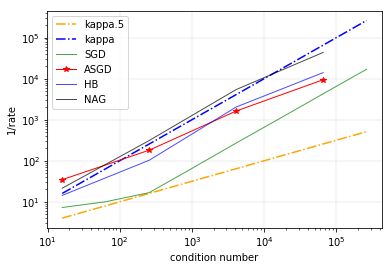

In [5]:
KP_1_x = np.array([np.min(k_set_8),np.max(k_set_8)])
KP_1_y = KP_1_x
KP_05_x = np.array([np.min(k_set_8),np.max(k_set_8)])
KP_05_y = np.sqrt(KP_05_x)
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.plot(KP_05_x, KP_05_y, linestyle = '-.',label='kappa.5',c='orange')
plt.plot(KP_1_x, KP_1_y, linestyle = '-.',label='kappa',c='b')

plt.plot(k_set_8,rate_SGD,c='g',linewidth=1.0, label='SGD',alpha=.7)
plt.plot(k_set_4,rate_ASGD,c='r',marker = '*', linewidth=1.0, label='ASGD')
plt.plot(k_set_4,rate_HB,c='b',linewidth=1.0, label='HB',alpha=.7)
plt.plot(k_set_4,rate_NAG,c='k',linewidth=1.0, label='NAG',alpha=.7)

plt.grid(color='k', linestyle='--', linewidth=.1)
plt.xlabel('condition number')
plt.ylabel('1/rate')
plt.legend()

In [95]:
from scipy.optimize import curve_fit

def Line(x, a, b):
    return a * x + b

para = curve_fit( Line, np.log(k_set_8), np.log(rate_SGD))[0]
SGD_fit = np.exp(Line(np.log(k_set_8), para[0], 0))
print('SGD:',para[0])

para = curve_fit( Line, np.log(k_set_4), np.log(rate_ASGD))[0]
ASGD_fit = np.exp(Line(np.log(k_set_8), para[0], 0))
print('ASGD:',para[0])

para = curve_fit( Line, np.log(k_set_4), np.log(rate_HB))[0]
HB_fit = np.exp(Line(np.log(k_set_8), para[0], 0))
print('HB:',para[0])

para = curve_fit( Line, np.log(k_set_4), np.log(rate_NAG))[0]
NAG_fit = np.exp(Line(np.log(k_set_8), para[0], 0))
print('NAG:',para[0])

SGD: 0.8453450685275723
ASGD: 0.6855592313671185
HB: 0.8527890506575468
NAG: 0.9272126811765098


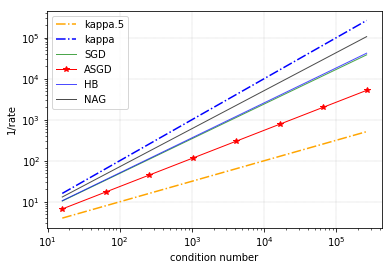

In [96]:
KP_1_x = np.array([np.min(k_set_8),np.max(k_set_8)])
KP_1_y = KP_1_x
KP_05_x = np.array([np.min(k_set_8),np.max(k_set_8)])
KP_05_y = np.sqrt(KP_05_x)
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.plot(KP_05_x, KP_05_y, linestyle = '-.',label='kappa.5',c='orange')
plt.plot(KP_1_x, KP_1_y, linestyle = '-.',label='kappa',c='b')

plt.plot(k_set_8,SGD_fit,c='g',linewidth=1.0, label='SGD',alpha=.7)
plt.plot(k_set_8,ASGD_fit,c='r',marker = '*', linewidth=1.0, label='ASGD')
plt.plot(k_set_8,HB_fit,c='b',linewidth=1.0, label='HB',alpha=.7)
plt.plot(k_set_8,NAG_fit,c='k',linewidth=1.0, label='NAG',alpha=.7)

plt.grid(color='k', linestyle='--', linewidth=.1)
plt.xlabel('condition number')
plt.ylabel('1/rate')
plt.legend()